# Example 2: Climate Variability


This second notebook showcases similar functionalities as example 1 but in addition it illustrates how **RADWave** can be used to estimate the influence of climate trends on regional wave patterns.

As in the previous notebook, we will be querying data already downloaded from the obtained from Australian Ocean Data Network portal [AODN](https://portal.aodn.org.au/). 

> We recomend to look at **RADWave** [documentation](https://radwave.readthedocs.io/en/latest/usage.html#getting-altimeter-values-from-data-providers) and the embeded video that explain how to select both a spatial bounding box and a temporal extent from the portal and how to export the file containing the `List of URLs`. This `TXT` file contains a list of `NETCDF` files for each available satellites. 


## Loading RADWave library and initialisation

We first start by importing **RADwave** library into our working space.

In [1]:
import io
import scipy
import requests
import numpy as np 
import pandas as pd

import RADWave as rwave

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

Here we will take the list of `NetCDF` URLs downloaded from the wave data portal containing the radar altimeter data for a region located offshore New Zealand ['../dataset/IMOS_NZ.txt']

For a detail overview of the options available in the `waveAnalysis` class, you can have a look at the [waveAnalysis API](https://radwave.readthedocs.io/en/latest/RADWave.html#RADWave.altiwave.waveAnalysis).

During initialisation we also specify:

+ `bbox` the bounding box of the geographical extent for the uploaded dataset following the convention [lon min,lon max,lat min,lat max] 
+ `stime` the starting time of wave climate analysis following the convention [year, month, day] [we chose the 1st of January 1985]
+ `etime` the ending time of wave climate analysis following the convention [year, month, day] [we chose the 31st of December 2018]

Here again, we don't specify a list of particular satellites to use (`satNames` keyword) so all of them will be queried. In other words we will look at all the records from the 10 altimeters: 

JASON-2 - JASON-3 - SARAL - SENTINEL-3A - CRYOSAT-2 - ENVISAT - GEOSAT - ERS-2 - GFO - TOPEX.

In [2]:
wa = rwave.waveAnalysis(altimeterURL='../dataset/IMOS_NZ.txt', bbox=[175.0,177.0,-47.0,-45.0], 
                  stime=[1985,1,1], etime=[2019,12,31])

# Processing altimeters data

After class initialisation querying the actual dataset is realised by calling the `processAltimeterData` function. The description of this function is available from the [API](https://radwave.readthedocs.io/en/latest/RADWave.html#RADWave.altiwave.waveAnalysis.processAltimeterData).

The function can take some times to execute depending on the number of NETCDF files to load and the size of the dataset to query (here it should not take more than **30 s**).

> **RADWave** uses the uploaded file containing the list of URLs to query via `THREDDS` the remote data. This operation can take *several minutes* and when looking at a large region it is recommended to divide the analyse in smaller regions and download a series of URLs text file instead of the entire domain directly.

In [3]:
wa.processAltimeterData(max_qc=1, altimeter_pick='all', saveCSV = 'altimeterData.csv')

Processing Altimeter Dataset 

   +  name JASON-2     / number of tracks 4   
   +  name JASON-3     / number of tracks 4   
   +  name SARAL       / number of tracks 4   
   +  name SENTINEL-3A / number of tracks 4   
   +  name CRYOSAT-2   / number of tracks 4   
   +  name ENVISAT     / number of tracks 4   
   +  name GEOSAT      / number of tracks 4   
   +  name ERS-2       / number of tracks 4   
   +  name GFO         / number of tracks 4   
   +  name TOPEX       / number of tracks 4   
 
Processing altimeter dataset took:  16 s


Once the dataset has been queried, we can plot the altimeter data points on a map using the `visualiseData` function.

This function **plots** and **saves** in a figure the geographical coordinates of processed altimeter data.

In [4]:
wa.visualiseData(title="Altimeter data tracks offshore New Zealand", extent=[166.,179.,-48.,-42.], 
                 addcity=None, markersize=30, zoom=8,
                 fsize=(10, 9), fsave=None)

# Computing wave regime and seasonality


## Time series

To perform wave analysis and compute the wave parameters discussed in the [documentation](https://radwave.readthedocs.io/en/latest/method.html#), we run the `generateTimeSeries` function. And we then plot these time series by calling the `plotTimeSeries` function. 

In [5]:
timeseries = wa.generateTimeSeries()

Max wave height: 8.948 m
Mean wave height: 3.221 m
Median wave height: 2.995 m
95th percentile wave height: 5.536 m


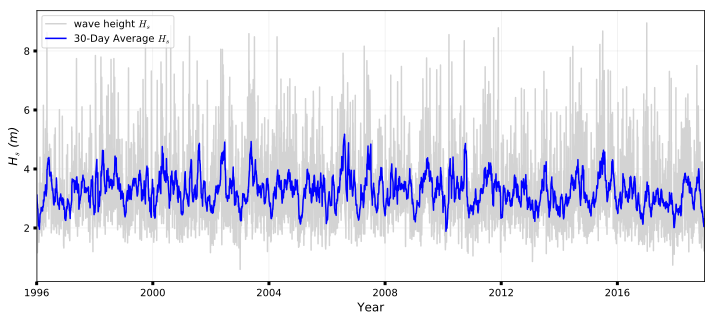

Max wave period: 12.887 s
Mean wave period: 7.406 s
Median wave period: 7.299 s
95th percentile wave period: 9.464 s


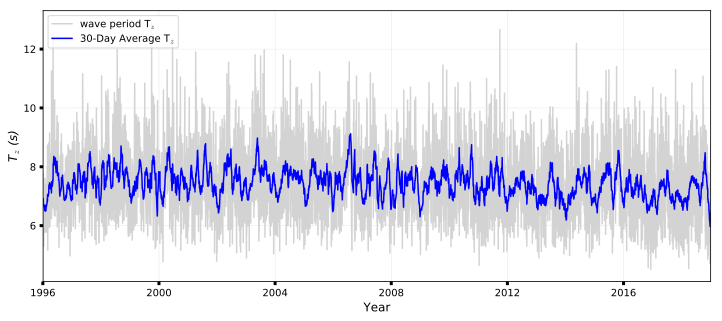

In [6]:
wa.plotTimeSeries(time=[1995,2019], series='H', fsize=(12, 5), fsave=None)
wa.plotTimeSeries(time=[1995,2019], series='T', fsize=(12, 5), fsave=None)

## Seasonability trends 

In addition to time series, we analyse the seasonal characteristics of the significant wave height and wave period computed from the altimeter dataset using the `computeSeasonalCharacteristics` function is provided in the [API](https://radwave.readthedocs.io/en/latest/RADWave.html#RADWave.altiwave.waveAnalysis.computeSeasonalCharacteristics).

### Significant wave height

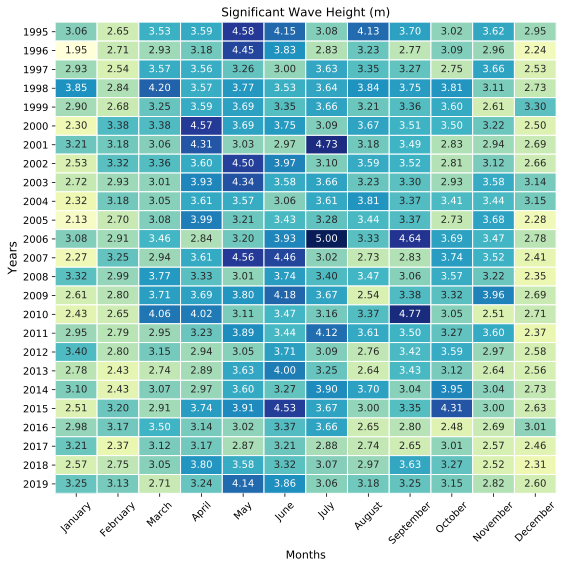

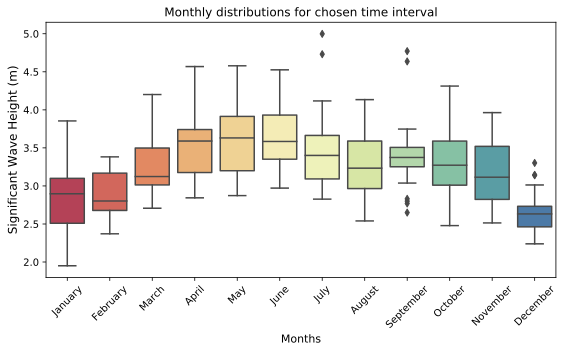

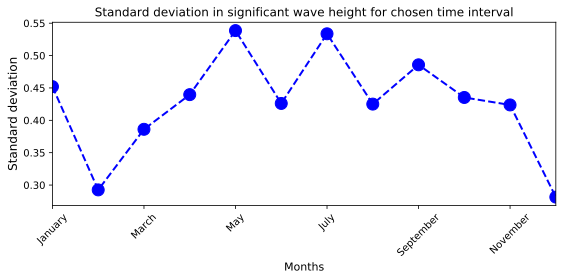

 
Change in yearly wave height trend accounting for seasonality:
    +           trend:  decreasing
    +    slope (cm/y):  -1.03


In [7]:
wh_all = wa.computeSeasonalCharacteristics(series='wh', time=[1995,2020], lonlat=None, fsave=None, plot=True)

### Wave period

Here we choose to only perform the calculation of the wave period seasonability but we don't plot the associated graphs.  

In [8]:
T_all = wa.computeSeasonalCharacteristics(series='period', time=[1995,2019], lonlat=None, fsave=None, plot=False)

> The function `computeSeasonalCharacteristics` returns 2 **Pandas dataframe** containing the mean monthly values of wave period `T_all` and significant wave height `wh_all`.


# 20-years analysis of the impact of climate trend 

Oscillation in atmospheric patterns is known to alter regional weather conditions and associated trends in wave climate [Godoi et al., 2016].

Here we illustrate how the results obtained with **RADWave** can be used to investigate how climate patterns may affect  wave parameters.

For the sake of the demonstration, we will focus our analysis on the following indices:

+ SOI - Southern Oscillation Index / [information](http://www.bom.gov.au/climate/enso/history/ln-2010-12/SOI-what.shtml)
+ AOI - Antarctic Oscillation Index / [information](https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/aao/aao_index.html)
+ SAMI - Southern Annular Mode Index / [information](http://www.bom.gov.au/climate/sam/)

We first load the data associated to each index using `Pandas` functionalities.

+ Godoi, V.A., Bryan, K.R. and Gorman, R.M., 2016. [Regional influence of climate patterns on the wave climate of the southwestern Pacific: The New Zealand region](https://agupubs.onlinelibrary.wiley.com/doi/pdf/10.1002/2015JC011572). Journal of Geophysical Research: Oceans, 121(6), pp.4056-4076.

In [24]:
# Defining the 20-years timeframe
time = [1998,2018] 

Monthly means of the SOI, AOI & SAMI index are sourced from the National Oceanic and Atmospheric Administration (**NOAA**) and the Natural Environment Research Council from the British Antarctic Survey (**NERC**). 

For each climate index the anomalies are computed by subtracting overall mean from the monthly means. 

Then, the same is done for the wave parameters in order to investigate how they are modulated by the climate modes.


## SOI - Southern Oscillation Index

In [10]:
# Dataset URL
url = "https://www.ncdc.noaa.gov/teleconnections/enso/indicators/soi/data.csv"

# Using Pandas to load the file content
soi = requests.get(url).content
soi_data = pd.read_csv(io.StringIO(soi.decode('utf-8')),skiprows=1)

# Define year and month of each record
soi_data['year'] = soi_data['Date'] // 100
soi_data['month'] = soi_data['Date'] % 100 

# Extract the information for the specified time interval 
soi_df = soi_data.drop(soi_data[soi_data.year < time[0]].index)
soi_df = soi_df.drop(soi_df[soi_df.year > time[1]].index)

# Calculate the 20-years mean 
soi_mean = soi_df['Value'].mean()

# Compute and store the anomalies in the dataframe
soi_df['anomaly'] = soi_df['Value']-soi_mean

## AOI - Antarctic Oscillation Index

In [13]:
# Dataset URL
url = "https://www.cpc.ncep.noaa.gov/products/precip/CWlink/daily_ao_index/aao/monthly.aao.index.b79.current.ascii"

# Using Pandas to load the file content
aoi = requests.get(url).content
aoi_data = pd.read_csv(io.StringIO(aoi.decode('utf-8')),delimiter=r"\s+",header=None)

# Rename columns to fit with RADWave dataframe
aoi_data = aoi_data.rename(columns={0:"year", 1:"month", 2:"Value"})

# Extract the information for the specified time interval 
aoi_df = aoi_data.drop(aoi_data[aoi_data.year < time[0]].index)
aoi_df = aoi_df.drop(aoi_df[aoi_df.year > time[1]].index)

# Calculate the 20-years mean 
aoi_mean = aoi_df['Value'].mean()

# Compute and store the anomalies in the dataframe
aoi_df['anomaly'] = aoi_df['Value']-aoi_mean

## SAMI - Southern Annular Mode Index

In [16]:
# Dataset URL
url = "http://www.nerc-bas.ac.uk/public/icd/gjma/newsam.1957.2007.txt"

# Using Pandas to load the file content
sam = requests.get(url).content
sam_data = pd.read_csv(io.StringIO(sam.decode('utf-8')),delimiter=r"\s+")

# Rename month values to fit with RADWave dataframe
sam_data = sam_data.rename(columns={"JAN":1, "FEB":2,
                      "MAR":3, "APR":4,
                      "MAY":5, "JUN":6,
                      "JUL":7, "AUG":8,
                      "SEP": 9, "OCT":10,
                      "NOV":11, "DEC":12})

# Rename columns to fit with RADWave dataframe
sam_data = sam_data.stack().reset_index()
sam_data = sam_data.rename(columns={"level_0":"year", "level_1":"month", 0:"Value"})


# Extract the information for the specified time interval 
sam_df = sam_data.drop(sam_data[sam_data.year < time[0]].index)
sam_df = sam_df.drop(sam_df[sam_df.year > time[1]].index)

# Calculate the 20-years mean 
sam_mean = sam_df['Value'].mean()

# Compute and store the anomalies in the dataframe
sam_df['anomaly'] = sam_df['Value']-sam_mean

## RADWave significant wave height and wave period anomalies

### Significant wave height

In [29]:
# Get monthly significant wave height 
wh_data = wa.timeseries.groupby(['year', 'month'])[['wh']].apply(np.mean).reset_index()

# Extract the information for the specified time interval 
wh_df = wh_data.drop(wh_data[wh_data.year < time[0]].index)
wh_df = wh_df.drop(wh_df[wh_df.year > time[1]].index)

# Calculate the 20-years mean 
wh_mean = wh_df['wh'].mean()

# Compute and store the anomalies in the dataframe
wh_df['anomaly'] = wh_df['wh']-wh_mean

### Wave period

In [30]:
# Get monthly mean wave period 
T_data = wa.timeseries.groupby(['year', 'month'])[['period']].apply(np.mean).reset_index()

# Extract the information for the specified time interval 
T_df = T_data.drop(T_data[T_data.year < time[0]].index)
T_df = T_df.drop(T_df[T_df.year > time[1]].index)

# Calculate the 20-years mean 
T_mean = T_df['period'].mean()

# Compute and store the anomalies in the dataframe
T_df['anomaly'] = T_df['period']-T_mean

## Correlations

Monthly mean anomalies of significant wave height and wave period can be correlated with monthly mean anomaly time series of the SOI, AOI & SAMI index by computing the **Pearson’s correlation coefficient** (R) for the region of interest. 

We use [scipy.stats.pearsonr](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.pearsonr.html) function to make this calculation. This function returns 2 values:

+ r: Pearson’s correlation coefficient.
+ p: Two-tailed p-value.

> Examples of **Pearson’s correlation coefficient** calculation between climate indices and the significant wave height are provided below:

In [37]:
# Pearson correlation between significant wave height and SOI
monthly_wh_soi = scipy.stats.pearsonr(soi_df['anomaly'],wh_df['anomaly']) 
print('+ Pearson correlation between significant wave height and SOI:',monthly_wh_soi[0],'\n')

# Pearson correlation between significant wave height and AOI
monthly_wh_aoi = scipy.stats.pearsonr(aoi_df['anomaly'],wh_df['anomaly']) 
print('+ Pearson correlation between significant wave height and AOI:',monthly_wh_aoi[0],'\n')

# Pearson correlation between significant wave height and SAMI
monthly_wh_sam = scipy.stats.pearsonr(sam_df['anomaly'],wh_df['anomaly']) 
print('+ Pearson correlation between significant wave height and SAMI:',monthly_wh_sam[0],'\n')

+ Pearson correlation between significant wave height and SOI: -0.08381145112994887 

+ Pearson correlation between significant wave height and AOI: -0.12895377184526083 

+ Pearson correlation between significant wave height and SAMI: -0.0041392692059833095 

